In [13]:
suppressMessages(library(snpStats))
suppressMessages(library(knockoff))
suppressMessages(library(tidyverse))
K <- 50
tmp.dir <- "/scratch/PI/candes/ukbiobank_tmp"

# Main parameters
chr <- 22
clumping <- "Radj5"

In [14]:
# Load group and knockoff swap information 
key.file <- sprintf("%s/knockoffs/%s_K50/ukb_gen_chr%d.key", tmp.dir, clumping, chr)
Variants <- read_delim(key.file, delim=" ", col_types=cols())

# Load LD table for augmented data
ld.file <- sprintf("%s/knockoff_diagnostics/%s_K50/ukb_gen_chr%d.ld", tmp.dir, clumping, chr)
LD <- read_table(ld.file, col_types=cols())

In [15]:
# Cross-reference list of variants with LD table
LD <- Variants %>% mutate(CHR_A=Chr, SNP_A=Variant, Group_A=Group, Knockoff_A=Knockoff) %>%
    select(CHR_A, SNP_A, Group_A, Knockoff_A) %>%
    right_join(LD, by=c("CHR_A", "SNP_A"))
LD <- Variants %>% mutate(CHR_B=Chr, SNP_B=Variant, Group_B=Group, Knockoff_B=Knockoff) %>%
    select(CHR_B, SNP_B, Group_B, Knockoff_B) %>%
    right_join(LD, by=c("CHR_B", "SNP_B"))

In [16]:
# Create correlation tables between different groups
group.range <- seq(0,10)
LD.XX <- LD %>% filter(abs(Group_B-Group_A) %in% group.range, Knockoff_A==FALSE, Knockoff_B==FALSE) %>%
    mutate(R.XX=R2) %>%
    mutate(SNP_A=str_replace(SNP_A,".A",""), SNP_A=str_replace(SNP_A,".B","")) %>%
    mutate(SNP_B=str_replace(SNP_B,".A",""), SNP_B=str_replace(SNP_B,".B","")) %>%
    select(Group_A, Group_B, SNP_A, SNP_B, R.XX) %>%
    distinct(Group_A, Group_B, SNP_A, SNP_B, R.XX)
LD.XXk <- LD %>% filter((Group_B-Group_A) %in% seq(1,10), Knockoff_A*Knockoff_B==FALSE) %>%
    mutate(R.XXk=R2) %>%
    mutate(SNP_A=str_replace(SNP_A,".A",""), SNP_A=str_replace(SNP_A,".B","")) %>%
    mutate(SNP_B=str_replace(SNP_B,".A",""), SNP_B=str_replace(SNP_B,".B","")) %>%
    select(Group_A, Group_B, SNP_A, SNP_B, R.XXk) %>%
    distinct(Group_A, Group_B, SNP_A, SNP_B, R.XXk)
LD.XkXk <- LD %>% filter(abs(Group_B-Group_A) %in% group.range, Knockoff_A==TRUE, Knockoff_B==TRUE) %>%
    mutate(R.XkXk=R2) %>%
    mutate(SNP_A=str_replace(SNP_A,".A",""), SNP_A=str_replace(SNP_A,".B","")) %>%
    mutate(SNP_B=str_replace(SNP_B,".A",""), SNP_B=str_replace(SNP_B,".B","")) %>%
    select(Group_A, Group_B, SNP_A, SNP_B, R.XkXk) %>%
    distinct(Group_A, Group_B, SNP_A, SNP_B, R.XkXk)

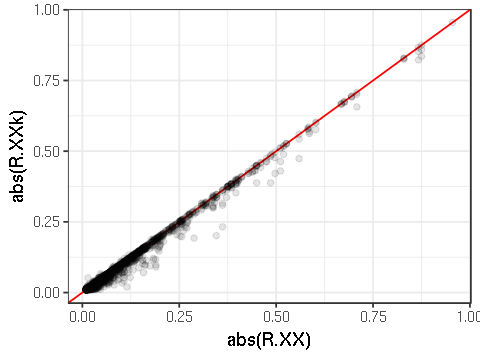

In [17]:
# Plot exchangeability
options(repr.plot.width=4, repr.plot.height=3)
LD.cross <- inner_join(LD.XX, LD.XXk, by = c("Group_A", "Group_B", "SNP_A", "SNP_B")) %>%
    filter(Group_A!=Group_B)
LD.cross %>%
    mutate(Distance = as.factor(abs(Group_A-Group_B))) %>%
    ggplot(aes(x=abs(R.XX), y=abs(R.XXk))) +
    geom_abline(color="red") +
    geom_point(alpha=0.1) +
    theme_bw()

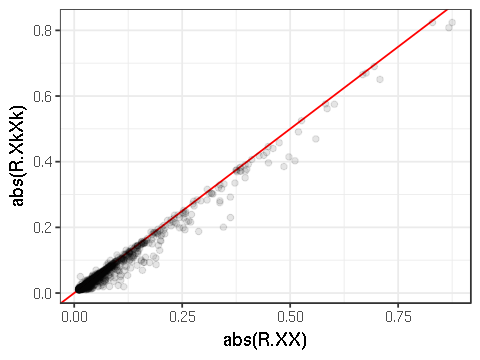

In [18]:
# Plot originality
LD.cross <- inner_join(LD.XX, LD.XkXk, by = c("Group_A", "Group_B", "SNP_A", "SNP_B")) %>%
        filter(Group_A!=Group_B)
LD.cross %>% 
    mutate(Distance = as.factor(abs(Group_A-Group_B))) %>%
    ggplot(aes(x=abs(R.XX), y=abs(R.XkXk))) +
    geom_abline(color="red") +
    geom_point(alpha=0.1) +
    theme_bw()

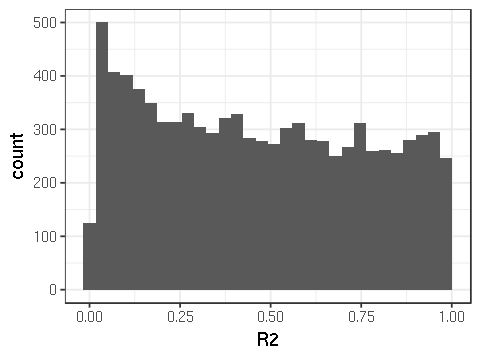

In [19]:
# Plot histogram of self-correlations
LD %>% filter(BP_A==BP_B) %>% 
    ggplot(aes(x=R2)) +
    geom_histogram(bins=30) +
    theme_bw()